## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

def load_troika_dataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def load_troika_data_file(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = load_troika_dataset()
        ppg, accx, accy, accz = load_troika_data_file(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def aggregate_error_metric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See aggregate_error_metric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = load_troika_dataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return aggregate_error_metric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):  # Name does not follow PEP8 style guidelines because of the following Test step
    """
    Perform pulse rate estimation and calculate error and confidence estimate for each pulse rate
    
    Args: 
        data_fl: file path to .mat file containing raw signals from PPG sensor and accelerometer
        ref_fl: file path to .mat file containing reference heart rates
    
    Returns:
        errors: pulse rate errors (in BPM)
        confidence: confidence estimates
    """    
    # Load data using load_troika_data_file
    ppg, accx, accy, accz = load_troika_data_file(data_fl)
    
    # Bandpass filter the signals
    ppg = bandpass_filter(ppg)
    accx = bandpass_filter(accx)
    accy = bandpass_filter(accy)
    accz = bandpass_filter(accz)
    
    # Compute pulse rate estimates and estimation confidence.
    
    # Consider only magnitude of acceleration
    acc = np.sqrt(accx**2 + accy**2 + accz**2) 
    
    # Load labels and convert them from column vector to row vector
    labels = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)  
    
    # Calculate heart rate estimates and confidence
    predictions, confidence = predict(acc, ppg)

    # Calculate errors
    errors = np.abs(np.subtract(predictions, labels))
        
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.array(errors), np.array(confidence)

    return errors, confidence

def bandpass_filter(s, fs=125):
    """
    Bandpass filter the signal between 40 and 240 BPM.
    
    Args: 
        s: raw signal from sensor
        fs: sampling frequency in Hz
    
    Returns:
        Bandpass-filtered signal.
    """    
    N = 3 # Order of the filter
    Wn = [40/60, 240/60] # Cutoff frequencies
    b, a = scipy.signal.butter(N, Wn, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, s)

def fft(signal, fs=125):
    """
    Calculate the Fast Fourier Transfrom of a sequence

    Args:
        signal: time-series
        fs: sampling frequency in Hz

    Returns:
        freqs: frequency bins 
        fft: magnitude of FFT
    """ 
    n_samples = len(signal)  # No zero padding
    freqs = np.fft.rfftfreq(n_samples, 1/fs)
    fft = np.abs(np.fft.rfft(signal, n_samples))
    return freqs, fft

def calculate_confidence(freqs, fft, freq, window_half_width=1):
    """
    Calculate the confidence value for a frequency as a heart rate estimate
    
    The confidence quantifies how much energy in the frequency spectrum is concentrated near the estimate

    Args:
        freqs: frequenqy bins used for FFT
        fft: magnitude of FFT
        freq: frequency corresponding to heart rate (in Hz)

    Returns:
        confidence: confidence estimate
    """
    # Window of 2 Hz centered on freq
    window = (freqs > freq - window_half_width) & (freqs < freq + window_half_width)  
    confidence = np.sum(fft[window]) / np.sum(fft)
    return confidence

def predict(acc, ppg, fs = 125, window_length_s=8, window_shift_s=2):
    """
    Calculate heart rate from PPG and accelerometer data

    Args:
        acc: time series representing magnitude of acceleration
        ppg: time series representing PPG signal
        fs: sampling frequency in Hz
        window_length_s: window_length in seconds
        window_shift_s: window shift in seconds

    Returns:
        predictions: heart rate predicitons 
        confidence: confidence estimates
    """
    # We go through the signals using overlapping windows
    window_length = window_length_s * fs  # 1000 samples
    window_shift = window_shift_s * fs  # 250 samples
    
    predictions = []
    confidence = []
    
    for start in range(0, len(ppg) - window_length + 1, window_shift):
        
        # Use only current window for estimation
        ppg_window = ppg[start:start+window_length]
        acc_window = acc[start:start+window_length]
        
        # Perform Fourier transform
        ppg_freqs, ppg_fft = fft(ppg_window)
        acc_freqs, acc_fft = fft(acc_window)
        
        # Remove unwanted frequencies 
        mask = (ppg_freqs>40/60) & (ppg_freqs<240/60)
        ppg_freqs = ppg_freqs[mask]
        ppg_fft = ppg_fft[mask]
        mask = (acc_freqs>40/60) & (acc_freqs<240/60)
        acc_freqs = acc_freqs[mask]
        acc_fft = acc_fft[mask]
        
        # Pick frequency with largerst FFT coefficient
        ppg_freq = ppg_freqs[np.argmax(ppg_fft, axis=0)]  
        acc_freq = acc_freqs[np.argmax(acc_fft, axis=0)]
        
        # Pick largerst frequency from PPG as heart rate estimate
        opt_freq = ppg_freq
        conf = calculate_confidence(ppg_freqs, ppg_fft, ppg_freq)
        
        # Check for another suitable frequency estimate if the dominant accelerometer frequency is the same as the PPG 
        if abs(ppg_freq - acc_freq) < 1e-3 :
            new_freq = ppg_freqs[np.argsort(ppg_fft, axis=0)[-2]]  # Pick frequency with second largerst FFT coefficient
            new_conf = calculate_confidence(ppg_freqs, ppg_fft, new_freq)
            if new_conf > conf:
                opt_freq = new_freq  # Choose second largest frequency if confidence is larger
                conf = new_conf
        
        pred = opt_freq * 60  # Convert from Hz to BPM
        
        predictions.append(pred)
        confidence.append(conf)
        
    return predictions, confidence

In [2]:
evaluate()

15.726958002724126

In [3]:
# Inspect time needed to produce a pulse rate estimate and a confidence value
import time
time_needed = []

# Merge evaluate, RunPulseRateAlgorithm and predict into the same block of code
data_fls, ref_fls = load_troika_dataset()
errs, confs = [], []
for data_fl, ref_fl in zip(data_fls, ref_fls):
    ppg, accx, accy, accz = load_troika_data_file(data_fl)
    ppg = bandpass_filter(ppg)
    accx = bandpass_filter(accx)
    accy = bandpass_filter(accy)
    accz = bandpass_filter(accz)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    window_length = 8 * 125
    window_shift = 2 * 125
    

    for start in range(0, len(ppg) - window_length + 1, window_shift):
        
        start_time = time.time()

        ppg_window = ppg[start:start+window_length]
        acc_window = acc[start:start+window_length]
        
        ppg_freqs, ppg_fft = fft(ppg_window)
        acc_freqs, acc_fft = fft(acc_window)
        mask = (ppg_freqs>40/60) & (ppg_freqs<240/60)
        ppg_freqs = ppg_freqs[mask]
        ppg_fft = ppg_fft[mask]
        mask = (acc_freqs>40/60) & (acc_freqs<240/60)
        acc_freqs = acc_freqs[mask]
        acc_fft = acc_fft[mask]

        ppg_freq = ppg_freqs[np.argmax(ppg_fft, axis=0)]  
        acc_freq = acc_freqs[np.argmax(acc_fft, axis=0)]
        
        opt_freq = ppg_freq
        conf = calculate_confidence(ppg_freqs, ppg_fft, ppg_freq)
        
        if abs(ppg_freq - acc_freq) < 1e-3 :
            new_freq = ppg_freqs[np.argsort(ppg_fft, axis=0)[-2]]  
            new_conf = calculate_confidence(ppg_freqs, ppg_fft, new_freq)
            if new_conf > conf:
                opt_freq = new_freq
                conf = new_conf
        
        end_time = time.time()
        
        time_needed.append(end_time - start_time)

avg_time = sum(time_needed)/len(time_needed)
max_time = max(time_needed)
print(f'The average time needed to produce a pulse rate estimate and a confidence value is {1e6*np.round(avg_time,9)} microseconds.')
print(f'The maximum time neeeded to produce a pulse rate estimate and a confidence value is {1e6*np.round(max_time,9)} microseconds.')

The average time needed to produce a pulse rate estimate and a confidence value is 142.841 microseconds.
The maximum time neeeded to produce a pulse rate estimate and a confidence value is 652.552 microseconds.


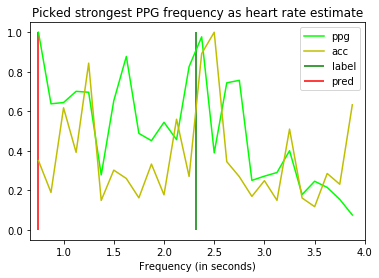

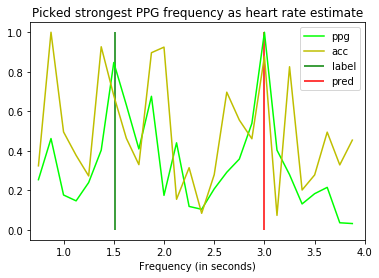

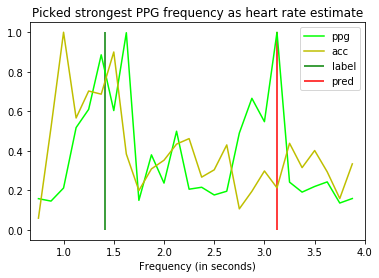

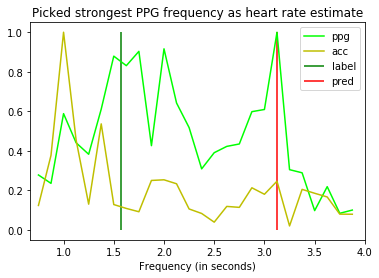

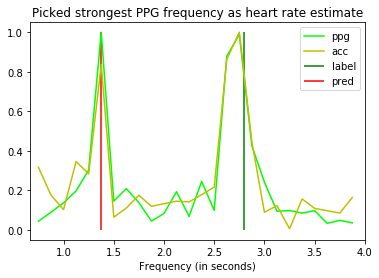

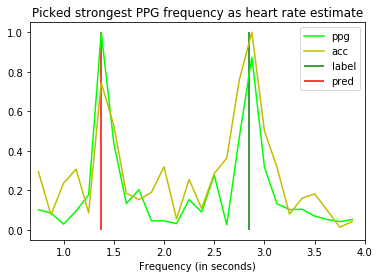

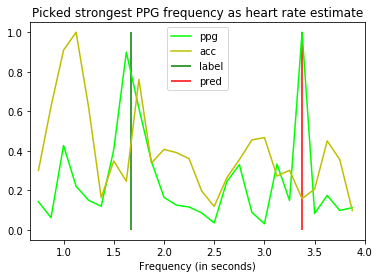

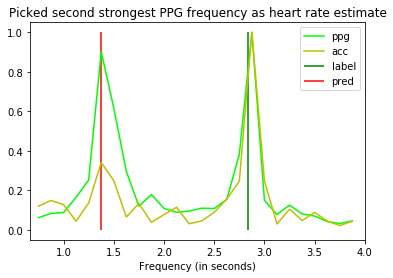

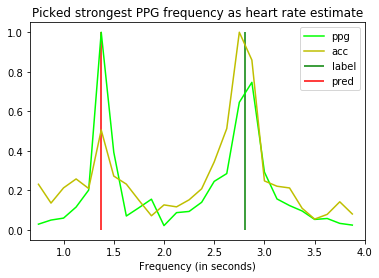

In [4]:
# Inspect some cases where the error is too big
import matplotlib.pyplot as plt
%matplotlib inline

# Merge evaluate, RunPulseRateAlgorithm and predict into the same block of code
data_fls, ref_fls = load_troika_dataset()
errs, confs = [], []
for data_fl, ref_fl in zip(data_fls, ref_fls):
    ppg, accx, accy, accz = load_troika_data_file(data_fl)
    ppg = bandpass_filter(ppg)
    accx = bandpass_filter(accx)
    accy = bandpass_filter(accy)
    accz = bandpass_filter(accz)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    labels = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    window_length = 8 * 125
    window_shift = 2 * 125
    
    label_idx = 0
    for start in range(0, len(ppg) - window_length + 1, window_shift):
        label = labels[label_idx]
        label = label / 60  # Convert from BPM to Hz       
        label_idx += 1
    
        ppg_window = ppg[start:start+window_length]
        acc_window = acc[start:start+window_length]
        
        ppg_freqs, ppg_fft = fft(ppg_window)
        acc_freqs, acc_fft = fft(acc_window)
        mask = (ppg_freqs>40/60) & (ppg_freqs<240/60)
        ppg_freqs = ppg_freqs[mask]
        ppg_fft = ppg_fft[mask]
        mask = (acc_freqs>40/60) & (acc_freqs<240/60)
        acc_freqs = acc_freqs[mask]
        acc_fft = acc_fft[mask]

        ppg_freq = ppg_freqs[np.argmax(ppg_fft, axis=0)]  
        acc_freq = acc_freqs[np.argmax(acc_fft, axis=0)]
        
        opt_freq = ppg_freq
        conf = calculate_confidence(ppg_freqs, ppg_fft, ppg_freq)
        message = 'Picked strongest PPG frequency as heart rate estimate'
        
        if abs(ppg_freq - acc_freq) < 1e-3 :
            new_freq = ppg_freqs[np.argsort(ppg_fft, axis=0)[-2]]  
            new_conf = calculate_confidence(ppg_freqs, ppg_fft, new_freq)
            if new_conf > conf:
                opt_freq = new_freq
                conf = new_conf
                message = 'Picked second strongest PPG frequency as heart rate estimate'
                
        error = abs(opt_freq - label)  # Error in Hz

        if error * 60 > 85:  # Display only errors higher that 85 BPM
            plt.figure()
            plt.plot(ppg_freqs, ppg_fft/np.max(ppg_fft), 'lime', label='ppg')  # FFT coefficients are normalized
            plt.plot(acc_freqs, acc_fft/np.max(acc_fft), 'y', label= 'acc')
            plt.vlines(label, 0, 1, label='label', color='g')
            plt.vlines(opt_freq, 0, 1, label='pred', color='r')
            plt.legend()
            plt.xlabel('Frequency (in seconds)')
            plt.xlim((40/60, 240/60))
            plt.title(message)
            plt.show()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a description of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

**Code Description**  
The code performs pulse rate estimation using the Troika dataset. You can run the algorithm using the top-level `evaluate` function. This function returns the mean absolute error at 90% availability. Please make sure to run the code cells in order. For instance, the code cell containing all the functions before running the code cell `evaluate()`. 
  
**Data Description**   
The data we used comes from the TROIKA dataset presented in the paper *TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise* by Zhang and co-authors [(link)](https://ieeexplore.ieee.org/document/6905737).  
The study included 12 male subjects aged 18 to 35. Raw signals were recorded from ECG and PPG sensors and a three-axis accelerometer. The signals were recorded during fast running at the peak speed of 15 km/h for one group of participants and 12 km/h for the other. The subjects were monitored during 5 minutes and all signals were sampled at 125 Hz. The dataset also includes heart rate values calculated from the ECG signal. These values were used as ground-truth labels during training of our algorithm.  
One limitation of the dataset is that it is not diverse enough. No women participated in the study and virtually only one age-group was represented. The dataset should also include different skin tones as the PPG sensors performs differently on different skin tones.  
Another thing to keep in mind is that sweating can affect the ECG signal. Therefore, the way the ground-truth labels were assigned is not completely robust to noise.     
  
**Algorithm Description**  

- We performs bandpass filtering on raw accelerometer and PPG signals (between 40 and 240 BPM) and we apply the Fourier transform to the filtered signals. The algorithm pick the PPG frequency with the largest FFT coefficient as the best estimate. If the frequency with the largest FFT coefficient is the same for both signals, then the algorithm tests the PPG frequency with the second largest FFT coefficient. If it is a good candidate, we use it as the final output. 
  
- We take advantage of the movement of the blood in the capillaries to monitor the activity of the heart. During systole, the capillaries are filled with blood, whereas during diastole, the heart refills with blood from the body. The PPG sensor uses a green light which is absorbed by the red blood cells. The changes in the amount of reflected light is detected by the sensor and helps us the follow the heart cycle.   
  
- The algorithm outputs the estimated heart rate (in BPM) along with a confidence score and an error metric. The confidence quantifies how much energy in the frequency spectrum is concentrated near the pulse rate estimate. The error metric is the Mean Absolute Error calculates using ground-truth labels.  

- The algorithm is not completely robust to noise due to arm movement.  
  
- There are two main causes of errors:  
1) The PPG frequency with the largest FFT coefficient doesn't necessarily correspond to the heart rate. This can happen when the PPG spectrum has two similar peaks: one from the heart rate and another from a noise source.  
2) The cadence of the arm swing can be the same as the heartbeat. So, picking the second strongest PPG frequency can sometimes give erroneous results.  
Both of these observations show the importance of the confidence estimation. Further improvements can be made to improve the way we calculate the confidence for a pulse rate estimate.  

**Algorithm Performance**   
We calculate the Mean Absolute Error between the estimates and the ground-truth labels. We rank the estimates in a descending order starting from the estimate with the highest confidence and we keep the first 90% of estimates to calculate the error.  
The mean absolute error is 14.10 at 90% availability on the training set.  
The mean absolute error is 9.13 at 90% availability on the test set.  
The algorithm performed relatively well on new data it hasn’t seen during training. This makes us believe it will generalize well.   
Having a lower error during testing might mean that the test examples are less challenging than the one used for training. This can also means that there is data leakage which can be avoided by using leave-one-subject-out cross-validation for testing.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 